In [6]:
import sys
sys.path.append("../") # go to parent dir

import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import module.chebyshev_solver as chb

import optax
from tqdm import tqdm

In [7]:
key = jax.random.PRNGKey(0)

## Idea
We parametrise the conductivity k with a guassian blob, parametrised by it two-dimensional position. Here we plot the loss function (Error in neumann boundaries) for the entire 2D grid of possible position values to find out about the structure of the loss function.

In [197]:
solver = chb.Solver(N = 10)
xx = solver.xx
yy = solver.yy
grid = solver.grid
dims = (solver.N, solver.N)
mask = np.ones(dims)
mask[1:-1,1:-1] = 0
maskx = np.ones(dims)
maskx[:,1:-1] = 0
masky = np.ones(dims)
masky[1:-1,:] = 0
mask = jnp.array(mask)
ii, jj = jnp.meshgrid(jnp.arange(solver.N), jnp.arange(solver.N))
a = 1.4
index_decay = jnp.exp(-(ii+jj)/a)

mu_init = jnp.array([0.5,0.8])
sigma = jnp.array(0.6) 
k_init = jnp.exp(-((xx - mu_init[0])**2+(yy - mu_init[1])**2) / sigma) + 0.1
k_cheby_init = solver.invI @ k_init.flatten()

key, _ = jax.random.split(key)

dirichlet_cheby = jax.random.normal(key, shape = dims) * index_decay
dirichlet = (solver.I @ dirichlet_cheby.flatten()).reshape(dims)
dirichlet *= mask

target_solution = solver.solve(k_cheby_init, dirichlet)

@jax.jit
def get_neumann(solution):
    jx = (solution["dx T"] * solution["k"]).reshape(dims)
    jy = (solution["dy T"] * solution["k"]).reshape(dims)

    neumann = jnp.concatenate((jx[:,0], jy[-1,:], jx[:,-1], jy[0,:]), axis = 0)
    return neumann

@jax.jit
def distance(solution, target_solution):
    neumann = get_neumann(solution)
    target_neumann = get_neumann(target_solution)

    return jnp.sum((neumann- target_neumann)**2)

In [200]:
@jax.jit
def get_k(mu, sigma):
    k = jnp.exp(-((xx - mu[0])**2+(yy - mu[1])**2) / sigma) + 0.1
    k_cheby = solver.invI @ k.flatten()
    return k_cheby

In [201]:
@jax.jit
def image(mu, sigma):
    return distance(solver.solve(get_k(mu, sigma), dirichlet), target_solution)

In [ ]:
### generate image

In [202]:
num = 30

im = np.zeros(shape = (num,num, 10))
for i, x in enumerate(jnp.linspace(-1,1, num)):
    for j, y in enumerate(jnp.linspace(-1,1, num)):
        for k, sigma in enumerate(jnp.linspace(0.3, 1, 10)):
            im[i,j, k] = image(jnp.array(jnp.array([x, y])), sigma)

            if (i**num*10 + j * 10 + k) % 30 == 0:
                print((i*num*10 + j * 10 + k)/ (num**2 * 10))

0.0
0.0033333333333333335
0.006666666666666667
0.01
0.013333333333333334
0.016666666666666666
0.02
0.023333333333333334
0.02666666666666667
0.03
0.035555555555555556
0.03888888888888889
0.042222222222222223
0.04555555555555556
0.04888888888888889
0.052222222222222225
0.05555555555555555
0.058888888888888886
0.06222222222222222
0.06555555555555556
0.06888888888888889
0.07222222222222222
0.07555555555555556
0.07888888888888888
0.08222222222222222
0.08555555555555555
0.08888888888888889
0.09222222222222222
0.09555555555555556
0.09888888888888889
0.1
0.10333333333333333
0.10666666666666667
0.11
0.11333333333333333
0.11666666666666667
0.12
0.12333333333333334
0.12666666666666668
0.13
0.13555555555555557
0.1388888888888889
0.14222222222222222
0.14555555555555555
0.14888888888888888
0.15222222222222223
0.15555555555555556
0.15888888888888889
0.1622222222222222
0.16555555555555557
0.1688888888888889
0.17222222222222222
0.17555555555555555
0.17888888888888888
0.18222222222222223
0.1855555555555

In [ ]:
### show loss function for different sizes of the gaussian blob

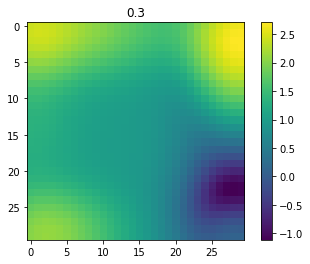

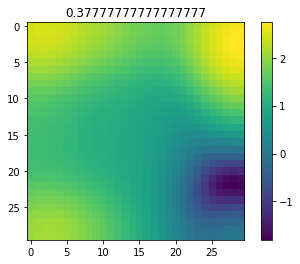

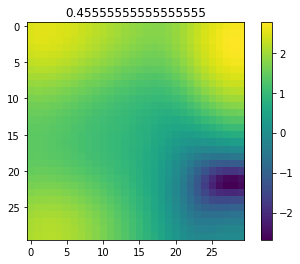

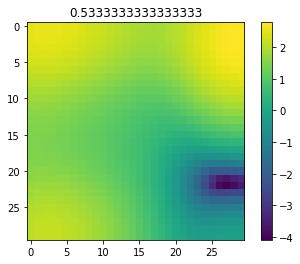

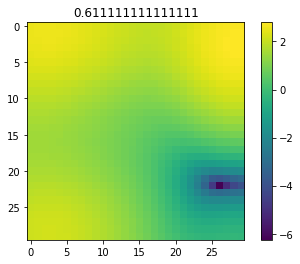

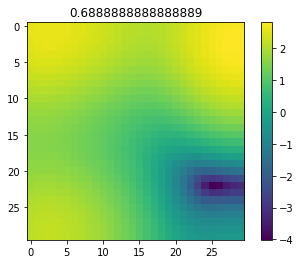

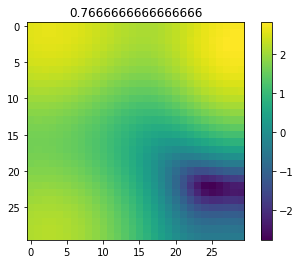

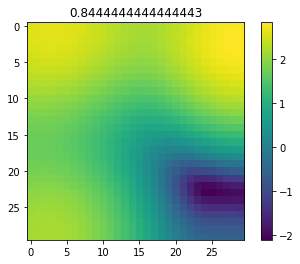

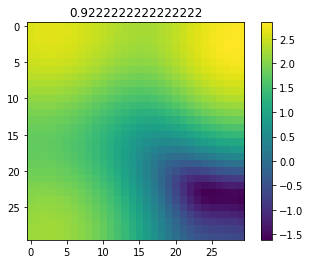

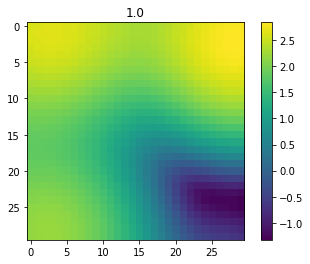

In [207]:
for i in range(10):
    plt.figure()
    plt.imshow(jnp.log(im[:,:,i]))
    plt.colorbar()
    plt.title(jnp.linspace(0.3, 1, 10)[i])

In [178]:
## the loss function always has well defined minimum

Array([0.3 , 0.65, 1.  ], dtype=float64)